# Подготовка

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.cuda.amp as amp
from torchvision.transforms import v2 as T
from torchvision.utils import save_image
import time
import random
import math

In [2]:
TRAIN_LABELS_PATH = "human_poses_data/train_answers.csv"
TRAIN_IMG_DIR = "human_poses_data/img_train/"
TEST_IMG_DIR = "human_poses_data/img_test/"

## Анализ

Первым шагом этого был анализ предоставленного датасета, в результате чего было выявлено неравномерное распределение классов и отсутствие некоторых из них.

In [ ]:
import pandas as pd

df = pd.read_csv(TRAIN_LABELS_PATH) 
def is_empty_like(value):
    if pd.isna(value):
        return True
    value = str(value).strip()
    return value == "" or value == "," or value.endswith(",")

empty_mask = df['target_feature'].apply(is_empty_like)
print(f"Количество пустых значений в 'target_feature': {empty_mask.sum()}")

empty_mask = df['img_id'].apply(is_empty_like)
print(f"Количество пустых значений в 'img_id': {empty_mask.sum()}")

print("Строки с пустыми значениями:")
print(df[empty_mask])

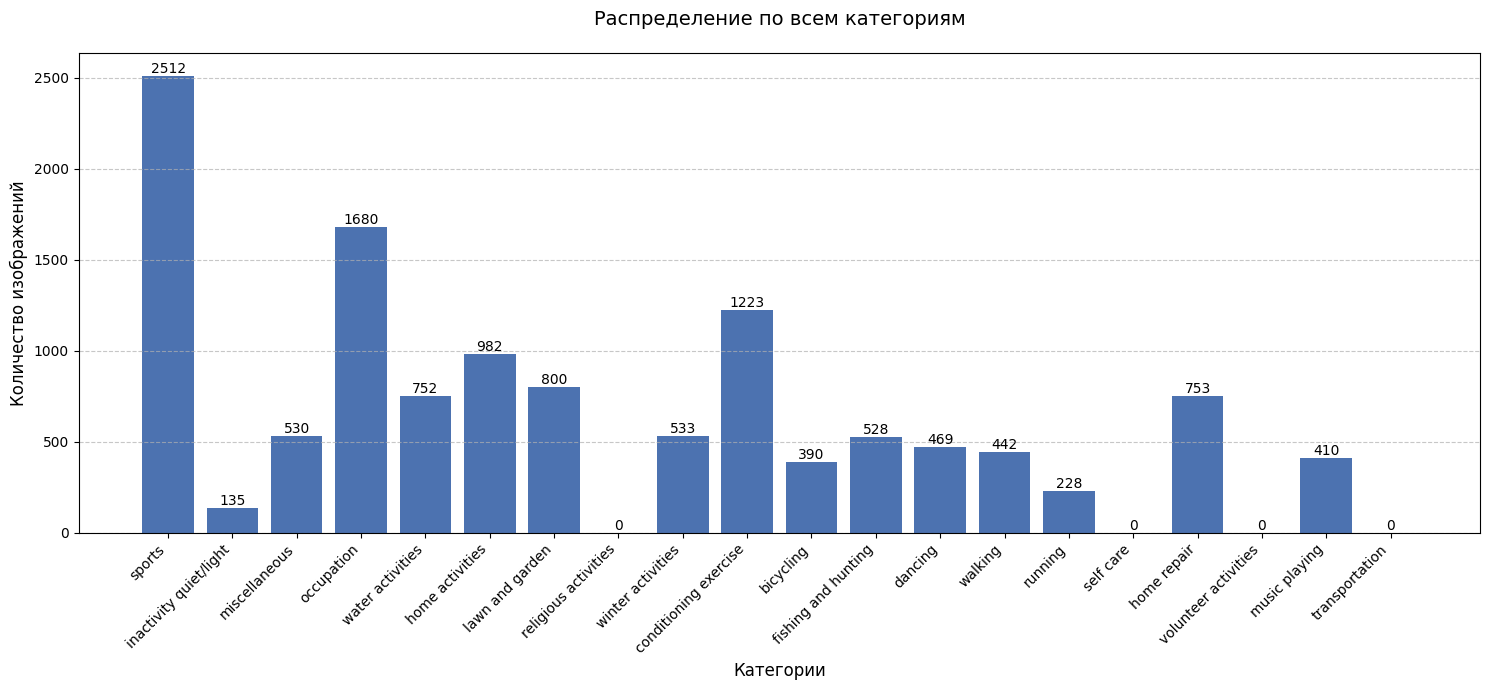

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(TRAIN_LABELS_PATH)
categories = df.iloc[:, 1].values 

df = pd.read_csv(TRAIN_IMG_DIR) 

dist_df = pd.DataFrame({
    'category_id': range(len(categories)),
    'category_name': categories
})

counts = df['target_feature'].value_counts().sort_index()
dist_df['count'] = dist_df['category_id'].map(counts).fillna(0)

plt.figure(figsize=(15, 7))
bars = plt.bar(dist_df['category_name'], dist_df['count'], color='#4c72b0')

plt.title('Распределение по всем категориям', fontsize=14, pad=20)
plt.xlabel('Категории', fontsize=12)
plt.ylabel('Количество изображений', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

Обучение проходило на локальных ПК, ввиду большей эффективности и надежности отностительно облачных сервисов (colab).

## Работа с датасетом

Был создан класс для обработки и взаимодейсвтия модели с датасетом

In [ ]:
class ActivityDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels = labels_df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path} | {e}")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
            
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = sorted(
            [f for f in os.listdir(img_dir) if f.endswith('.jpg')],
            key=lambda x: int(x.split('.')[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        img_id = int(self.image_files[idx].split('.')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id
    

Далее была попытка создать собственнный датасет, расиширив маленькие классы до размера большего, используя аугментированные изображения того же класса, но это лишь навердило обучнию. Спустя 10 эпох модель показывает 0.5 F1 меры и перестает учиться.

Представленная ниже аугментация уравниванла количество фотографий во всех классах с контролем яркости. Данная аугментация не показала рост F1, при различных гиперпараметрах.

In [ ]:
img_dir = r'C:\Users\st115763\Downloads\human_poses_data\img_train'
csv_path = r'C:\Users\st115763\Downloads\human_poses_data\train_answers.csv'
output_dir = r'C:\Users\st115763\Downloads\human_poses_data\data_512'
target_samples = 2512
IMG_SIZE = 512

class SafeAugmentation:
    def __init__(self):
        self.transform = T.Compose([
            T.Resize(IMG_SIZE),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=11),
            T.ToTensor(),
            self._safe_normalize,
            self._brightness_check
        ])
    
    def _safe_normalize(self, tensor):
        """Безопасная нормализация с защитой от черных изображений"""
        mean = torch.tensor([0.45, 0.45, 0.45]).view(3, 1, 1)
        std = torch.tensor([0.225, 0.225, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std
    
    def _brightness_check(self, tensor):
        """Коррекция слишком темных изображений"""
        if tensor.mean() < 0.15:
            tensor = (tensor * 1.8).clamp(-2, 2)
        return tensor
    
    def __call__(self, img):
        return self.transform(img)

def save_with_quality_check(tensor, path):
    """Сохраняет только изображения с достаточной яркостью"""
    if tensor.mean() > 0.18:
        save_image(tensor, path)
    else:
        corrected = (tensor * 2.0).clamp(-1, 1)
        save_image(corrected, path)

def balance_classes():
    print("=== БАЛАНСИРОВКА КЛАССОВ ===")
    start_time = time.time()
    df = pd.read_csv(csv_path, header=None, names=['filename', 'class'])
    df['filename'] = df['filename'].astype(str) + '.jpg'
    augmenter = SafeAugmentation()
    os.makedirs(output_dir, exist_ok=True)
    class_groups = df.groupby('class')['filename'].apply(list)
    
    for class_id, files in tqdm(class_groups.items(), desc="Балансировка классов"):
        class_dir = os.path.join(output_dir, str(class_id))
        os.makedirs(class_dir, exist_ok=True)
        
        for filename in tqdm(files, desc=f"Копирование оригиналов класса {class_id}", leave=False):
            try:
                img = Image.open(os.path.join(img_dir, filename)).convert('RGB')
                save_path = os.path.join(class_dir, f"orig_{filename}")
                img.save(save_path)
            except Exception as e:
                print(f"Ошибка копирования {filename}: {e}")

        current_count = len(files)
        needed = max(0, target_samples - current_count)
        
        if needed == 0:
            continue
            
        print(f"\nКласс {class_id}: {current_count} -> {target_samples} (аугментаций: {needed})")
        

        augmented_count = 0
        pbar = tqdm(total=needed, desc=f"Аугментация класса {class_id}")
        
        while augmented_count < needed:
            for filename in random.sample(files, len(files)):
                if augmented_count >= needed:
                    break
                    
                try:
                    img = Image.open(os.path.join(img_dir, filename)).convert('RGB')
                    
                    for _ in range(5):
                        augmented = augmenter(img)
                        if augmented.mean() > 0.15: 
                            break
                        augmented = (augmented * 1.5).clamp(-1, 1)
                    
                    save_path = os.path.join(class_dir, f"aug_{augmented_count}_{filename}")
                    save_with_quality_check(augmented, save_path)
                    augmented_count += 1
                    pbar.update(1)
                    
                except Exception as e:
                    print(f"Ошибка аугментации {filename}: {e}")
        
        pbar.close()

    print(f"\nГотово! Время выполнения: {time.time() - start_time:.2f} сек.")
    print(f"Сбалансированные данные сохранены в: {output_dir}")

if __name__ == '__main__':
    balance_classes()

Были выбраны наиболее подходящие и эффективные аугментации, применяемые на оригинальном датасете.


In [ ]:
IMG_SIZE = 512

train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=20,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
    ),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


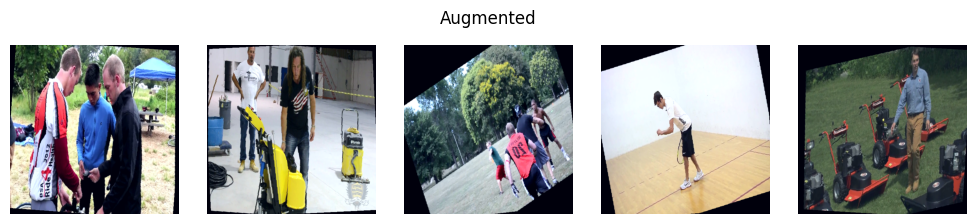

In [ ]:
labels_df = pd.read_csv(TRAIN_LABELS_PATH)

train_data_augm = ActivityDataset(img_dir=TRAIN_IMG_DIR, labels_df=labels_df, transform=train_transform)

plt.figure(figsize=(10, 6))
plt.suptitle("Augmented")
for i in range(5):
    image = train_data_augm[i]
    plt.subplot(3, 5, i + 1)
    plt.axis('off')
    plt.imshow(torch.clamp(train_data_augm[i][0].permute(1, 2, 0) * 0.25 + 0.5, 0, 1))
    
plt.tight_layout()
plt.show()


# Обучение

## Функциональная база

Функция для обучения на GPU

In [ ]:
def train_model_gpu(model, train_dataset, val_dataset, WEIGHTS, EPOCHS, DEVICE, BATCH_SIZE, LR):
    criterion = nn.CrossEntropyLoss(weight=WEIGHTS)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    scaler = amp.GradScaler()

    sampler = WeightedRandomSampler(WEIGHTS, num_samples=len(train_dataset), replacement=True)

    train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    best_f1 = 0.0
    history = {'train_loss': [], 'val_f1': [], 'val_acc': [], 'val_precision': [], 'val_recall': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
        
        for images, labels in progress:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            progress.set_postfix({'loss': f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(train_dataset)
        
        # Валидация
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)
                
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Расчет метрик
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(epoch_loss)
        history['val_f1'].append(epoch_f1)
        history['val_acc'].append(epoch_acc)
        history['val_precision'].append(epoch_precision)
        history['val_recall'].append(epoch_recall)
        
        # Сохранение лучшей модели
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), 'best_shufflenet.pth')
            print(f"Epoch {epoch+1}: Новая лучшая модель сохранена с F1: {epoch_f1:.4f}")
        
        scheduler.step(epoch_loss)
        
        print(f"\nEpoch {epoch+1}/{EPOCHS} завершена:")
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Val Accuracy: {epoch_acc:.4f}")
        print(f"Val F1: {epoch_f1:.4f}")
        print(f"Val Precision: {epoch_precision:.4f}")
        print(f"Val Recall: {epoch_recall:.4f}\n")
        
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_f1'], label='F1-score', marker='o')
    plt.plot(history['val_acc'], label='Accuracy', marker='o')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_precision'], label='Precision', marker='o')
    plt.plot(history['val_recall'], label='Recall', marker='o')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    return history

Функция для обучения на CPU

In [ ]:
def train_model_gpu(model, train_dataset, val_dataset, WEIGHTS, EPOCHS, DEVICE, BATCH_SIZE, LR):
    criterion = nn.CrossEntropyLoss(weight=WEIGHTS)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    sampler = WeightedRandomSampler(WEIGHTS, num_samples=len(train_dataset), replacement=True)

    train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    best_f1 = 0.0
    history = {'train_loss': [], 'val_f1': [], 'val_acc': [], 'val_precision': [], 'val_recall': []}
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
        
        for images, labels in progress:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad(set_to_none=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            
            running_loss += loss.item() * images.size(0)
            progress.set_postfix({'loss': f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(train_dataset)
        
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(epoch_loss)
        history['val_f1'].append(epoch_f1)
        history['val_acc'].append(epoch_acc)
        history['val_precision'].append(epoch_precision)
        history['val_recall'].append(epoch_recall)
        
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), 'best_shufflenet.pth')
            print(f"Epoch {epoch+1}: Новая лучшая модель сохранена с F1: {epoch_f1:.4f}")
        
        scheduler.step(epoch_loss)
        
        print(f"\nEpoch {epoch+1}/{EPOCHS} завершена:")
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Val Accuracy: {epoch_acc:.4f}")
        print(f"Val F1: {epoch_f1:.4f}")
        print(f"Val Precision: {epoch_precision:.4f}")
        print(f"Val Recall: {epoch_recall:.4f}\n")
        
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_f1'], label='F1-score', marker='o')
    plt.plot(history['val_acc'], label='Accuracy', marker='o')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_precision'], label='Precision', marker='o')
    plt.plot(history['val_recall'], label='Recall', marker='o')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    return history

## Модели

Были опробованы различные модели. Лучшие результаты показал ShuffleNet.

### Efficient CNN 64

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                    stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                    stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.act(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            DepthwiseSeparableConv(channels, channels),
            DepthwiseSeparableConv(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)

class EfficientCNN64(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        self.stage1 = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=2),
            ResidualBlock(64)
        )

        self.stage2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128, stride=2),
            ResidualBlock(128),
            ResidualBlock(128)
        )

        self.stage3 = nn.Sequential(
            DepthwiseSeparableConv(128, 256, stride=2),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        self.stage4 = nn.Sequential(
            DepthwiseSeparableConv(256, 384, stride=1),
            ResidualBlock(384)
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384, 192),
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(192, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x)
        return self.classifier(x)
    
summary(EfficientCNN64(), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 32, 32]             288
            Conv2d-5           [-1, 64, 32, 32]           2,048
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              SiLU-7           [-1, 64, 32, 32]               0
DepthwiseSeparableConv-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]             576
           Conv2d-10           [-1, 64, 32, 32]           4,096
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             SiLU-12           [-1, 64, 32, 32]               0
DepthwiseSeparableConv-13           [-1, 64, 32, 32]               0
           Conv2d-14          

### Efficient CNN 128

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                    stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                    stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.act(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            DepthwiseSeparableConv(channels, channels),
            DepthwiseSeparableConv(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)

class EfficientCNN128(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )

        self.stage1 = nn.Sequential(
            DepthwiseSeparableConv(64, 128, stride=2),
            ResidualBlock(128),
            ResidualBlock(128)
        )

        self.stage2 = nn.Sequential(
            DepthwiseSeparableConv(128, 256, stride=2),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        self.stage3 = nn.Sequential(
            DepthwiseSeparableConv(256, 512, stride=2),
            ResidualBlock(512),
            ResidualBlock(512)
        )

        self.stage4 = nn.Sequential(
            DepthwiseSeparableConv(512, 768, stride=1),
            ResidualBlock(768),
            ResidualBlock(768)
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 512),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x)
        return self.classifier(x)

summary(EfficientCNN128(), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              SiLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]             576
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              SiLU-7          [-1, 128, 32, 32]               0
DepthwiseSeparableConv-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]           1,152
           Conv2d-10          [-1, 128, 32, 32]          16,384
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             SiLU-12          [-1, 128, 32, 32]               0
DepthwiseSeparableConv-13          [-1, 128, 32, 32]               0
           Conv2d-14          

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=20):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

summary(CNN(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Linear-13                  [-1, 256]       1,048,832
             ReLU-14                  [

### ShuffleNetV2

Были попытки изменять глубину и ширину, однако лучшие результаты получены не были.

In [5]:
def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups
    x = x.view(batchsize, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batchsize, -1, height, width)
    return x

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        branch_features = oup // 2
        
        assert self.stride in [1, 2]
        
        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True)
            )
        else:
            self.branch1 = nn.Sequential()
            
        self.branch2 = nn.Sequential(
            nn.Conv2d(inp if (self.stride > 1) else branch_features, 
                      branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True)
        )
        
    @staticmethod
    def depthwise_conv(i, o, kernel_size, stride):
        return nn.Conv2d(i, o, kernel_size, stride, (kernel_size-1)//2, groups=i, bias=False)
    
    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)
            
        out = channel_shuffle(out, 2)
        return out

class ShuffleNetV2(nn.Module):
    def __init__(self, stages_repeats=[4, 8, 4], stages_out_channels=[24, 176, 352, 704, 1024], num_classes=20):
        super(ShuffleNetV2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, stages_out_channels[0], 3, 2, 1, bias=False),
            nn.BatchNorm2d(stages_out_channels[0]),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.stages = []
        for idxstage in range(len(stages_repeats)):
            stage = self._make_stage(stages_out_channels[idxstage], 
                                     stages_out_channels[idxstage+1], 
                                     stages_repeats[idxstage])
            self.stages.append(stage)
            self.add_module(f'stage{idxstage+2}', stage)
            
        self.conv5 = nn.Sequential(
            nn.Conv2d(stages_out_channels[-2], stages_out_channels[-1], 1, 1, 0, bias=False),
            nn.BatchNorm2d(stages_out_channels[-1]),
            nn.ReLU(inplace=True)
        )
        
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(stages_out_channels[-1], num_classes)
        
    def _make_stage(self, inp, oup, repeat):
        layers = []
        layers.append(InvertedResidual(inp, oup, stride=2))
        for _ in range(repeat-1):
            layers.append(InvertedResidual(oup, oup, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        for stage in self.stages:
            x = stage(x)
        x = self.conv5(x)
        x = self.globalpool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x


summary(ShuffleNetV2(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
              ReLU-3           [-1, 24, 32, 32]               0
         MaxPool2d-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 24, 8, 8]             216
       BatchNorm2d-6             [-1, 24, 8, 8]              48
            Conv2d-7             [-1, 88, 8, 8]           2,112
       BatchNorm2d-8             [-1, 88, 8, 8]             176
              ReLU-9             [-1, 88, 8, 8]               0
           Conv2d-10           [-1, 88, 16, 16]           2,112
      BatchNorm2d-11           [-1, 88, 16, 16]             176
             ReLU-12           [-1, 88, 16, 16]               0
           Conv2d-13             [-1, 88, 8, 8]             792
      BatchNorm2d-14             [-1, 8

### Resnet-18


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
    
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=20):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        

        return x


summary(ResNet18(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
    ResidualBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### SqueezeNet

In [7]:
import math


class ResidualBlock(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(squeeze_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(expand_planes)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(expand_planes)
        self.relu2 = nn.ReLU(inplace=True)

        # using MSR initilization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2./n))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        out1 = self.conv2(x)
        out1 = self.bn2(out1)
        out2 = self.conv3(x)
        out2 = self.bn3(out2)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out


class SqueezeNet(nn.Module):
    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1) # 32
        self.bn1 = nn.BatchNorm2d(96)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16
        self.fire2 = ResidualBlock(96, 16, 64)
        self.fire3 = ResidualBlock(128, 16, 64)
        self.fire4 = ResidualBlock(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 8
        self.fire5 = ResidualBlock(256, 32, 128)
        self.fire6 = ResidualBlock(256, 48, 192)
        self.fire7 = ResidualBlock(384, 48, 192)
        self.fire8 = ResidualBlock(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 4
        self.fire9 = ResidualBlock(512, 64, 256)
        self.conv2 = nn.Conv2d(512, 10, kernel_size=1, stride=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=4)
        self.softmax = nn.LogSoftmax(dim=1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)
        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)
        x = self.fire9(x)
        x = self.conv2(x)
        x = self.avg_pool(x)
        x = self.softmax(x)
        return x


summary(SqueezeNet(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 64, 64]           2,688
       BatchNorm2d-2           [-1, 96, 64, 64]             192
              ReLU-3           [-1, 96, 64, 64]               0
         MaxPool2d-4           [-1, 96, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,552
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]           1,088
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]           9,280
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12          [-1, 128, 32, 32]               0
    ResidualBlock-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 16,

## Гиперпараметры

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = 512
LR = 0.001
NUM_CLASSES = 20

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Обучение модели

In [ ]:
full_labels = pd.read_csv(TRAIN_LABELS_PATH)

train_labels, val_labels = train_test_split(
    full_labels, test_size=0.1, stratify=full_labels['target_feature'], random_state=42
)

train_dataset = ActivityDataset(TRAIN_IMG_DIR, train_labels, train_transform)
val_dataset = ActivityDataset(TRAIN_IMG_DIR, val_labels, test_transform)

all_class_counts = full_labels['target_feature'].value_counts().sort_index()
class_weights_full = 1.0 / all_class_counts

class_weights_full = class_weights_full.reindex(range(NUM_CLASSES), fill_value=0.0)
WEIGHTS = torch.DoubleTensor([class_weights_full[label] for label in train_labels['target_feature']])

In [ ]:
model = ShuffleNetV2(num_classes=NUM_CLASSES).to(DEVICE)

history = train_model_gpu(model, train_dataset, val_dataset, WEIGHTS, EPOCHS, DEVICE, BATCH_SIZE, LR)

## Предсказания

In [ ]:
def predict_test(model):
    model.load_state_dict(torch.load('best_shufflenet.pth', map_location=DEVICE))
    model.eval()
    
    test_dataset = TestDataset(TEST_IMG_DIR, test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    preds = []
    ids = []
    
    with torch.no_grad():
        for images, batch_ids in tqdm(test_loader, desc="Predicting"):
            images = images.to(DEVICE)
            outputs = model(images)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(batch_preds)
            ids.extend(batch_ids.numpy())
    
    pd.DataFrame({'Id': ids, 'target_feature': preds}).to_csv('shufflenet_submission.csv', index=False)
    print("Predictions saved to shufflenet_submission.csv")

In [ ]:
predict_test(model)

# Итоги

## Лучшая модель

Лучшей моделью стал ShuffleNet и показал следующие результаты:

## Результат

Train Loss: 0.0378

Val Accuracy: 0.7187

Val F1: 0.7169

Val Precision: 0.7203

Val Recall: 0.7187

![](best.jpg)

## Вывод

В результате данных соревнований был получен опыт проведения первичного анализа, обработки датасета. Было проведено сравнение архитектур сверточных нейронных сетей. Были построены, оптимизированы и обучены различные нейронные сети. Лучшей моделью для классификации изображений для нашей команды в рамках данной задачи оказалась модель ShuffleNet.